## Automated Portfolio Management

### Complete Example

#### Includes:
- Data collection
- Goal setting and probability
- Projections

In [2]:
import sys
sys.path.append('../src')

from projections import Projection
from datetime import date
from goals import Goal
import riskevaluation as rv
import pyportfolio as py


In [5]:
myGoal = Goal(
    "Retirement",
    target_year=2041,
    target_value=3000000,
    initial_contribution=50000,
    monthly_contribution=500,
    priority="Wishes",
)

In [6]:
evalulation = rv.RiskEvaluation()

In [7]:
evalulation.capacity_evaluation.answer_questionnaire()
evalulation.tolerance_evaluation.answer_questionnaire()

You are able to spend money regularly.
0:Completely False
1:Somewhat True
2:Completely True


You can pay all your monthly bills on time.
0:Completely False
1:Somewhat True
2:Completely True


If you lose money investing today, your current lifestyle will not change.
0:Completely False
1:Somewhat True
2:Completely True


You do not need to draw more that 5% of your investment portfolio for the next 5 years.
0:Completely False
1:Somewhat True
2:Completely True


In general, how would your bestfriend describe you as a risk taker?
0:A real gambler
1:Willing to take risks after doing alot of research
2:Cautious
3:A real risk avoider


You are on TV at a game show. Which of the following options would you choose?
0:$1,000 in cash
1:A 50% chance at $5,000
2:A 25% chance at %10,000
3:A 5% change at $100,000


What word comes to mind first wen you think of risk?
0:Loss
1:Uncertainty
2:Opportunity
3:Thrill




In [8]:
tol_score = evalulation.capacity_evaluation.calculate_score()
cap_score = evalulation.tolerance_evaluation.calculate_score()

Risk Score:
Completely True: 3
Somewhat True: 2
Completely True: 3
Somewhat True: 2
Total Risk Score: 10

Risk Score:
Willing to take risks after doing alot of research: 6
A 50% chance at $5,000: 2
Uncertainty: 2
Total Risk Score: 10



In [11]:
myPortfolioId = py.Portfolio.get_portfolio_mapping(tol_score, cap_score)

In [12]:
myPortfolio = py.Portfolio(
    portfolio_name="Moderate Growth",
    ticker_string="VTI TLT IEI GLD DBC",
    expected_return=0.06,
    risk_bucket=myPortfolioId,
)

[*********************100%***********************]  5 of 5 completed


In [13]:
yearsToGoal = myGoal.target_year - date.today().year
myProjection = Projection(
    expected_return=myPortfolio.expected_return,
    expected_risk=myPortfolio.expected_risk,
    initial_investment=myGoal.initial_contribution,
    monthly_investment=myGoal.monthly_contribution,
    years=yearsToGoal,
)

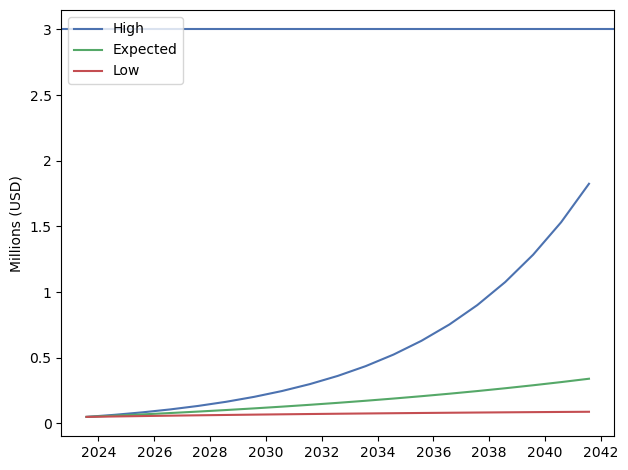

In [14]:
myProjection.visualize(myGoal.target_value)

### Goal Probability

Since our goal looks very unrealistic, we can add a feature that allows us to calculate the probability of reaching our goal using some stats magic. 

We will use the z-score which assumes that our data follows a normal distribution.

In [9]:
def goal_probability_for_amount(
    goalAmount,
    expectedReturn,
    portfolioRisk,
    years,
    initialInvestment,
    monthlyInvestment,
) -> float:
    """
    calculate the probability of reaching a goal amount
    """
    import scipy.stats as st
    import math as math
    from projections import Projection

    std = portfolioRisk / math.sqrt(years)
    amount = 0
    minReturn = 0.00
    while amount < goalAmount:
        minReturn = minReturn + 0.0000001
        amount = Projection.return_projection(
            minReturn, initialInvestment, monthlyInvestment, years
        )
    z_score = (minReturn - expectedReturn) / std
    return 1 - st.norm.cdf(z_score)


def calculate_monthly_minimum(
    exprectedReturn, initialInvestment, years, goalAmount
) -> float:
    """
    uses the future value formula to find out the needed monthly contribution
    """
    monthlyInvestment = (
        goalAmount - (initialInvestment * pow(1 + exprectedReturn / 12, (years * 12)))
    ) / ((pow(1 + exprectedReturn / 12, (years * 12)) - 1) / (exprectedReturn / 12))
    return monthlyInvestment

In [10]:
# the probability of reaching our goal in practically
goal_probability_for_amount(
    myGoal.target_value,
    myPortfolio.expected_return,
    myPortfolio.expected_risk,
    yearsToGoal,
    myGoal.initial_contribution,
    myGoal.monthly_contribution,
)

3.053637009919896e-08

In [11]:
monthlyMin = calculate_monthly_minimum(
    myPortfolio.expected_return,
    myGoal.initial_contribution,
    yearsToGoal,
    myGoal.target_value,
)

print(f"Minumum monyhly contribution: ${monthlyMin:.2f}")

Minumum monyhly contribution: $7365.79


Let's see how the probability changes when we update our monthly contribution to the new minumum. I think we will use a nice round number too, so let's contribute $7500 *(yikes!)* each month .

In [12]:
myGoal.monthly_contribution = 7500.00

In [13]:
# updated probability of reaching our goal in practically
goal_probability_for_amount(
    myGoal.target_value,
    myPortfolio.expected_return,
    myPortfolio.expected_risk,
    yearsToGoal,
    myGoal.initial_contribution,
    myGoal.monthly_contribution,
)

# 52% is alot better than where we were!

0.5237871286309681

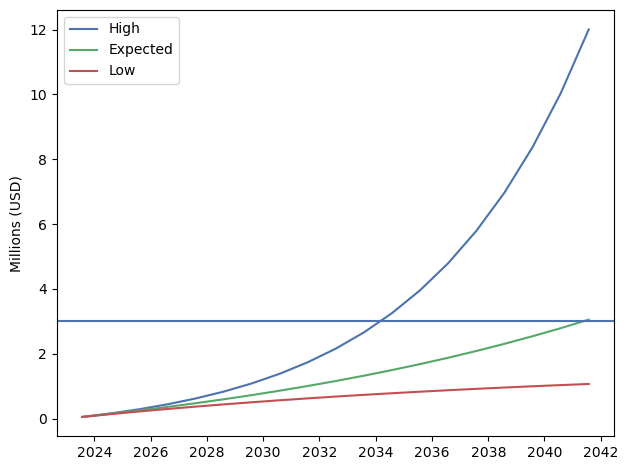

In [14]:
myProjection = Projection(
    myPortfolio.expected_return,
    myPortfolio.expected_risk,
    myGoal.initial_contribution,
    myGoal.monthly_contribution,
    yearsToGoal,
)
myProjection.visualize(myGoal.target_value)

In [15]:
# now let's extend our retirement age a bit to see if we can make things even better
goal_probability_for_amount(
    myGoal.target_value,
    myPortfolio.expected_return,
    myPortfolio.expected_risk,
    yearsToGoal + 2,  # add two years
    myGoal.initial_contribution,
    myGoal.monthly_contribution,
)

0.7364140859987943

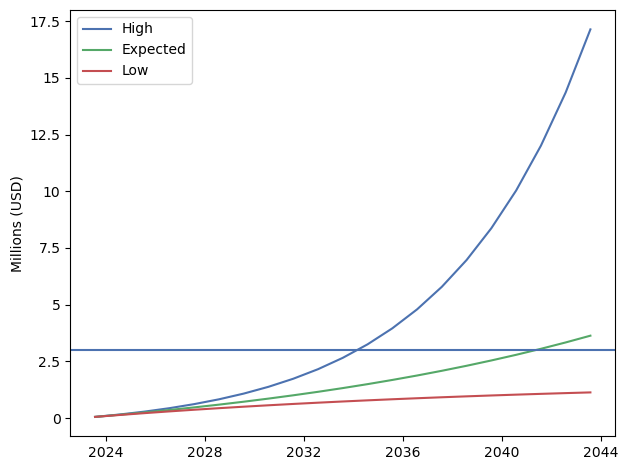

In [16]:
myProjection = Projection(
    myPortfolio.expected_return,
    myPortfolio.expected_risk,
    myGoal.initial_contribution,
    myGoal.monthly_contribution,
    yearsToGoal + 2,
)
myProjection.visualize(myGoal.target_value)